In [22]:
import os
import pandas as pd
import numpy as np
from collections import Counter

# Visualization

import matplotlib.pyplot as plt
import plotly.express as px

In [24]:
def spline(input):

    return abs(input)

def ReLu(input):
    return max(0.1*input,input)

In [25]:
class Neuron:

    def __init__(self,input,activation_type = "ReLu"):
       
       self.pre_layer = input
       self.value = self.output(self.pre_layer)
       self.activation = activation_type

    def output(self,input):
        
        '''
        Input : Value of nodes from previous layer
        sum : Adding together nodes after passing them through activation function (Bspline)

        '''
        # length = len(input)
        sum = 0
        for i in input:

            sum += spline(i)

        return sum

In [26]:
x = [-1,-2,-3,-4,-5,-6]

In [27]:
y = Neuron(x)

In [28]:
y.value

21

In [34]:
from scipy import interpolate

In [32]:
ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1)])

x1=ctr[:,0]
y1=ctr[:,1]

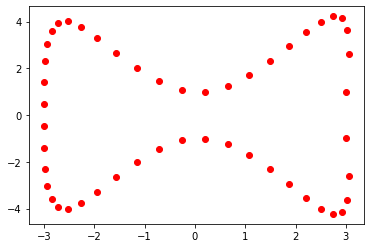

In [53]:
# plt.plot(x1,y1,"ro")
plt.plot(out[0],out[1],"ro")

In [36]:

tck,u = interpolate.splprep([x1,y1],k=3,s=0)

In [44]:
tck[0]

array([0.        , 0.        , 0.        , 0.        , 0.23337426,
       0.36457052, 0.5       , 0.63542948, 0.76662574, 1.        ,
       1.        , 1.        , 1.        ])

In [38]:
u

array([0.        , 0.102178  , 0.23337426, 0.36457052, 0.5       ,
       0.63542948, 0.76662574, 0.897822  , 1.        ])

In [50]:
out[1]

array([ 1.        ,  2.61056076,  3.62454074,  4.13348082,  4.22892189,
        4.00240484,  3.54547054,  2.94965989,  2.30651377,  1.70757306,
        1.24437866,  1.00847144,  1.08541318,  1.45746847,  2.01965647,
        2.66425634,  3.28354721,  3.76980823,  4.01538488,  3.9509726 ,
        3.6098907 ,  3.04244275,  2.29893231,  1.42966296,  0.48493825,
       -0.48493825, -1.42966296, -2.29893231, -3.04244275, -3.6098907 ,
       -3.9509726 , -4.01538488, -3.76980823, -3.28354721, -2.66425634,
       -2.01965647, -1.45746847, -1.08541318, -1.00847144, -1.24437866,
       -1.70757306, -2.30651377, -2.94965989, -3.54547054, -4.00240484,
       -4.22892189, -4.13348082, -3.62454074, -2.61056076, -1.        ])

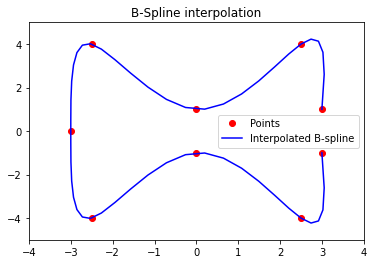

In [45]:
u=np.linspace(0,1,num=50,endpoint=True)
out = interpolate.splev(u,tck)

plt.figure()
plt.plot(x1, y1, 'ro', out[0], out[1], 'b')
plt.legend(['Points', 'Interpolated B-spline', 'True'],loc='best')
plt.axis([min(x1)-1, max(x1)+1, min(y1)-1, max(y1)+1])
plt.title('B-Spline interpolation')
plt.show()